In [1]:
import numpy as np

import matplotlib.pyplot as plt

from photutils.datasets import apply_poisson_noise
from astropy.modeling import models
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.nddata import StdDevUncertainty
import astropy.units as u

from specreduce.compat import Spectrum as Spectrum1D
from specutils.fitting import fit_generic_continuum

from specreduce.calibration_data import load_pypeit_calibration_lines
from specreduce.utils.synth_data import make_2d_arc_image, make_2d_spec_image
from specreduce.tracing import FlatTrace
from specreduce.extract import BoxcarExtract
from specreduce.line_matching import match_lines_wcs, find_arc_lines

In [2]:
%load_ext autoreload
%autoreload 2

The FITS WCS standard implements ideal world coordinate functions based on the physics
of simple dispersers. This is described in detail by Paper III,
https://www.aanda.org/articles/aa/pdf/2006/05/aa3818-05.pdf. This can be used to model a
non-linear dispersion relation based on the properties of a spectrograph. This example
models the MMTO Blue Channel Spectrograph with the 500 lines/mm grating:

In [4]:
blue_channel_header = {
    'CTYPE1': 'AWAV-GRA',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 1344,        # Reference pixel [pix]
    'CRVAL1': 5410,        # Reference value [Angstrom]
    'CDELT1': 1.19,        # Linear dispersion [Angstrom/pix]
    'PV1_0': 5.0e5,        # Grating density [1/m]
    'PV1_1': 1,            # Diffraction order
    'PV1_2': 8.05,         # Incident angle [deg]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

bc_linear_header = {
    'CTYPE1': 'AWAV',  # Grating dispersion function with air wavelengths
    'CUNIT1': 'Angstrom',  # Dispersion units
    'CRPIX1': 1344,       # Reference pixel [pix]
    'CRVAL1': 5410,      # Reference value [Angstrom]
    'CDELT1': 1.19,       # Linear dispersion [Angstrom/pix]
    'CTYPE2': 'PIXEL',     # Spatial detector coordinates
    'CUNIT2': 'pix',       # Spatial units
    'CRPIX2': 1,           # Reference pixel
    'CRVAL2': 0,           # Reference value
    'CDELT2': 1            # Spatial units per pixel
}

blue_channel_wcs = WCS(header=blue_channel_header)
bc_linear_wcs = WCS(header=bc_linear_header)

This figure shows the difference between a constant dispersion per pixel vs the spectrograph model.

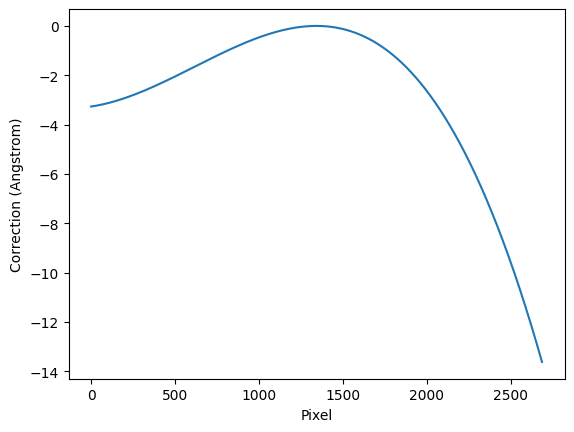

In [5]:
pix_array = np.arange(2688)
nlin = blue_channel_wcs.spectral.pixel_to_world(pix_array)
lin = bc_linear_wcs.spectral.pixel_to_world(pix_array)
resid = (nlin - lin).to(u.Angstrom)
plt.plot(pix_array, resid)
plt.xlabel("Pixel")
plt.ylabel("Correction (Angstrom)")
plt.show()

Create a synthetic 2D image using the non-linear WCS and with curvature in the cross-dispersion direction. The `HeNe` and `Ar` lamps are the optimal ones to use for this spectrograph configuration. For the purposes of this example, the curvature along the cross-dispersion axis is exaggerated compared to the actual spectrograph.

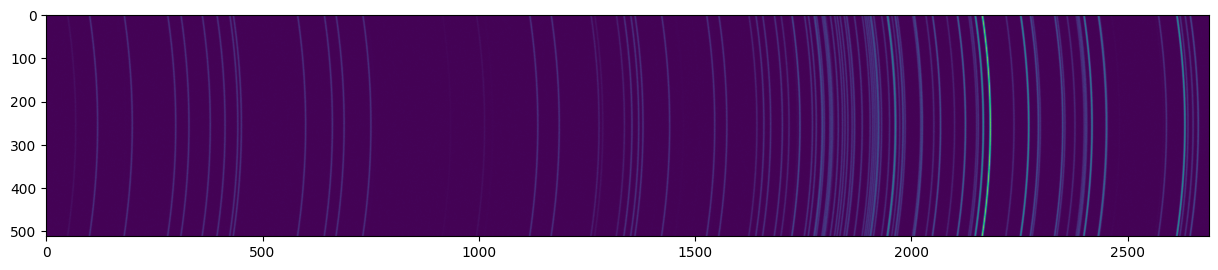

In [6]:
tilt_mod = models.Legendre1D(degree=2, c0=25, c1=0, c2=50)
match_im = make_2d_arc_image(
    nx=2688, 
    ny=512, 
    linelists=['HeI', 'NeI', 'ArI'], 
    wcs=blue_channel_wcs, 
    line_fwhm=3, 
    tilt_func=tilt_mod, 
    amplitude_scale=1e-2
)
fig = plt.figure(figsize=(15, 5))
plt.imshow(match_im)

Load the linelist used to create the image, set up the trace and boxcar extraction of the center of the image, and subtract the background in the extracted spectrum. The `specutils` line-finding routines expect background-subtracted spectra.

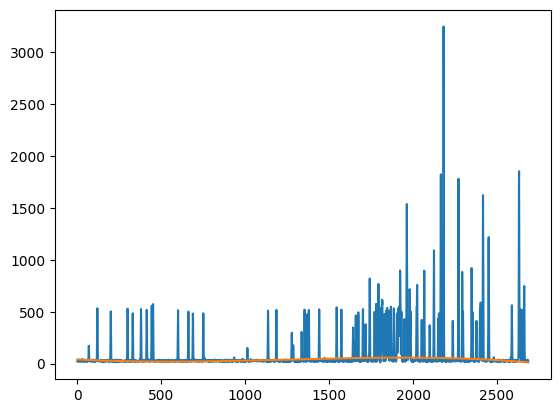

In [7]:
arclist = load_pypeit_calibration_lines(['HeI', 'NeI', 'ArI'])['wavelength']
trace = FlatTrace(match_im, 256)
arc_sp = BoxcarExtract(match_im, trace, width=5).spectrum
arc_sp.uncertainty = StdDevUncertainty(np.sqrt(arc_sp.flux).value)
continuum = fit_generic_continuum(arc_sp, median_window=51)
arc_sub = Spectrum1D(spectral_axis=arc_sp.spectral_axis, flux=arc_sp.flux - continuum(arc_sp.spectral_axis))
arc_sub.uncertainty = arc_sp.uncertainty

fig = plt.figure()
plt.plot(arc_sp.spectral_axis, arc_sp.flux)
plt.plot(arc_sp.spectral_axis, continuum(arc_sp.spectral_axis))
plt.show()

Find the emission lines in the extracted and background-subtracted spectrum and try matching it against the linear WCS. Only lines within a portion of the spectrum will be within a 3 pixel tolerance. 

In [18]:
cenlist = find_arc_lines(arc_sub, fwhm=3, window=3, noise_factor=10)
matched_list = match_lines_wcs(
    pixel_positions=cenlist['centroid'], 
    catalog_wavelengths=arclist, 
    spectral_wcs=bc_linear_wcs.spectral, 
    tolerance=3
)
matched_list

pixel_center,wavelength
pix,Angstrom
float64,float64
68.10402761233307,3889.75
118.80817972910366,3950.097
198.88089288639196,4045.561
299.30436753651406,4165.354
329.86563391761365,4201.858
379.1861800332951,4260.561
413.26129002739253,4301.311
442.82154105638637,4336.557


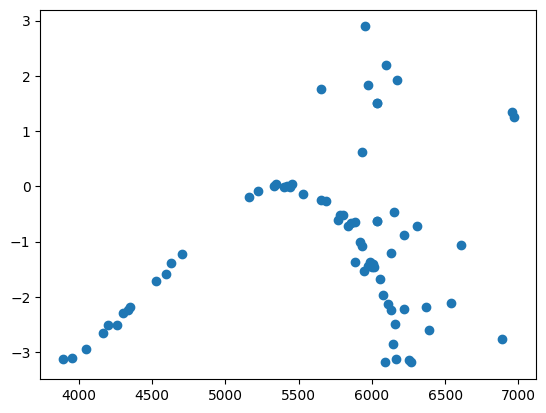

In [19]:
fig = plt.figure()
pred_wavelengths = bc_linear_wcs.spectral.pixel_to_world(matched_list['pixel_center'])
residuals = matched_list['wavelength'] - pred_wavelengths.to(u.Angstrom)
plt.scatter(matched_list['wavelength'], residuals)
plt.show()

This attempt works pretty well up until about 5500 Angstroms. Red-ward of that, the arc lines become crowded and the grating model diverges further from the linear model. There is enough to start with for fitting a wavelength calibration solution. However, we will need functionality to reject spurious lines from the fitting process. This is often done iteratively. Start with no rejection, perform a fit, enable rejection, and then re-fit. 